In [1]:
%matplotlib inline
import warnings
import itertools
import pandas as pd
import numpy as np
import subprocess, psycopg2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from datetime import datetime
plt.style.use('fivethirtyeight')

## Get the data from the Heroku PostgreSQL database

In [2]:
HEROKU_APP_NAME = "pxl-ss"
TABLE_NAME = "Temperature"

conn_info = subprocess.run(["heroku", "config:get", "DATABASE_URL", "-a", HEROKU_APP_NAME], stdout = subprocess.PIPE)
connuri = conn_info.stdout.decode('utf-8').strip()

engine = create_engine(connuri)
raw_engine = engine.raw_connection()

data = pd.read_sql_query("SELECT * FROM Temperature;", raw_engine)

## Restructure the data to form a time series

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 2 columns):
creation_date    128 non-null datetime64[ns]
value            128 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 2.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 128 entries, 2018-11-10 23:38:44.453789 to 2018-11-11 21:40:08.215890
Data columns (total 1 columns):
value    128 non-null float64
dtypes: float64(1)
memory usage: 2.0 KB
None


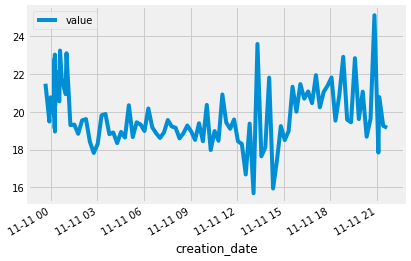

In [9]:
df = pd.DataFrame(data, columns = ['creation_date', 'value'])

# Inspect data
print(df.info())

# Convert the creation_date column to datetime64
df['creation_date'] = pd.to_datetime(df['creation_date'])
# Convert the value column to float
df['value'] = pd.to_numeric(df['value'])

# Set date_creation column as index
df.set_index('creation_date', inplace=True)

# Inspect data
print(df.info())

# Plot data
df.plot()
plt.show()

In [4]:
my_df = df['value'].resample('60T').mean()

In [6]:
my_df.head()

creation_date
2018-11-10 23:00:00    20.554000
2018-11-11 00:00:00    21.200256
2018-11-11 01:00:00    20.132500
2018-11-11 02:00:00    18.845000
2018-11-11 03:00:00    19.197500
Freq: 60T, Name: value, dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 4 columns):
id               128 non-null int64
value            128 non-null object
place            128 non-null object
creation_date    128 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.1+ KB
None
